In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

### Hyperparameters initialisation:

In [2]:
#dimension of the vector beta_i: it has p features we want to learn. Here p=beta_dim
beta_dim =100

In [3]:
#The input x is a scalar and here its dimension is 1
input_dim = 1

In [5]:
#we need to set up a few parameters for the high dimensional feature function PHI:
#here phi is assumed to be a radial basis kernel function

#number of rbf centers
num_phi_rbf = 100 #used to be 100

#sigma of the radial basis function
phi_rbf_sigma =5.0 #used to be 1

#we need to learn phi using a NN. We assume it has 2 hidden layers, each with 10 neurons
phi_hidden_layer_size = 20 

In [6]:
#dimension of the latent variable z that embeds beta
z_dim = 25

In [7]:
# Gives the numbers of betas to learn
num_training_funcs = 1000 

In [8]:
#each function f_i is evaluated at K locations. Here K=num_eval_points
#this is the K in the piVAE paper: number of locations where we evaluate each fct/each path:
K = 20

In [9]:
encoder_h_dim_1 = 512
encoder_h_dim_2 = 512
encoder_h_dim_3 = 128

decoder_h_dim_1 = 128
decoder_h_dim_2 = 128
decoder_h_dim_3 = 128

### Ornstein Uhlenbeck PROCESS - SDE: 
Parameters are the volatility $\sigma>0$, the mean $\mu,$ and $\theta>0.$ . The SDE (Langevin Equation) for a OU process is given by: 
### $ dX_t=\theta(\mu - X_t)dt+\sigma dW_t, $ 
where $W_t$ is a Wiener process.

In [10]:
dt = 0.001

n_steps=1000

In [11]:
#set of indices between 0 and n_steps-1
indices= [i for i in range(n_steps)]
indices_np=np.array(indices)
indices_np.shape

(1000,)

In [12]:
indices_lims=[0,999]

In [13]:
theta=2.0
sigma=1.0
mu=0.0

In [14]:
stationary_variance=sigma**2/(2*theta)
stationary_std=sigma/(np.sqrt(2*theta))
stationary_std

0.5

In [15]:
def generate_OU_dataset():
    
    indices_append=[]
    OU_value_at_K_locations_append=[]

    for fct_id in range(num_training_funcs):  
        
        #for each sampled path, we draw different parameter values for sigma, mu and theta:
        #sigma = np.random.uniform(2.0,6.0)
        #mu = np.random.uniform(0.0, 0.1)     
        #theta = np.random.uniform(3.0, 7.0)
        
        OU_simulated_path = np.zeros(n_steps)
        OU_value_at_K_locations=np.zeros(K)
            
        OU_simulated_path[0]=np.random.uniform(-5,5)
        
        #OU_simulated_path[0]=np.random.normal(mu, stationary_std)      
        
        for i in range(n_steps-1):  
            OU_simulated_path[i + 1] = OU_simulated_path[i] + (mu - OU_simulated_path[i]) * theta * dt + sigma * np.sqrt(dt) * np.random.randn()          
    
        indices_sampled=np.random.choice(indices, K, replace=False)
        indices_sampled=np.sort(indices_sampled)
        
        for j in range(K):                                           
            OU_value_at_K_locations[j]=OU_simulated_path[indices_sampled[j]]            

        indices_append.append(indices_sampled)
                
        OU_value_at_K_locations_append.append(OU_value_at_K_locations)        
        
        indices_append_np =np.array(indices_append)
        
        OU_np=np.array(OU_value_at_K_locations_append)
    
    
    return np.expand_dims(indices_append_np,2), np.expand_dims(OU_np,2)
        

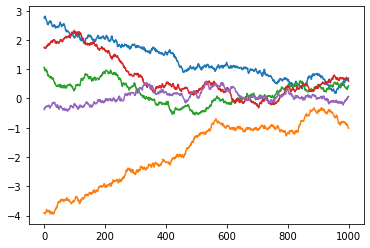

In [16]:
for i in range(5):
    OU_simulated_path = np.zeros(n_steps)
    
    OU_simulated_path[0]=np.random.uniform(-5,5)

    #OU_simulated_path[0]=np.random.normal(mu, stationary_std)
    
    for j in range(n_steps-1):  
        OU_simulated_path[j + 1] = OU_simulated_path[j] + (mu - OU_simulated_path[j]) * theta * dt + sigma * np.sqrt(dt) * np.random.randn()          
    
    plt.plot(OU_simulated_path)

In [17]:
dataset_indices, dataset_OU = generate_OU_dataset()

In [18]:
#the dataset paths only contain K=100 points
dataset_OU.shape

(1000, 20, 1)

In [19]:
dataset_indices.shape

(1000, 20, 1)

In [20]:
dataset_OU = np.transpose(dataset_OU, (0, 2, 1))
dataset_OU.shape

(1000, 1, 20)

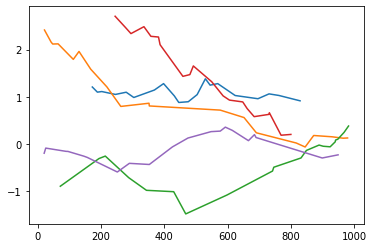

In [21]:
#these plots don't correspond to a whole OU path with 1000 points - they only contain K points
for i in range(5):
    plt.plot(dataset_indices[i,:,0],dataset_OU[i,0,:])
plt.show()

In [22]:
#convert the dataset indices into float
dataset_indices = np.array(dataset_indices, dtype=float)
dataset_indices.dtype

dtype('float64')

In [23]:
#convert all the indices to float
indices_float=np.array(indices, dtype=float)
#indices_float

In [24]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()                                  
             
        self.phi_rbf_centers =nn.Parameter(torch.tensor(
            np.random.choice(indices_float,num_phi_rbf)).unsqueeze(1))
        self.phi_nn_1 = nn.Linear(num_phi_rbf, phi_hidden_layer_size)
        self.phi_nn_2 = nn.Linear(phi_hidden_layer_size, beta_dim)

        self.encoder_nn_1 = nn.Linear(beta_dim, encoder_h_dim_1)
        self.encoder_nn_2 = nn.Linear(encoder_h_dim_1, encoder_h_dim_2)
        self.encoder_nn_3 = nn.Linear(encoder_h_dim_2, encoder_h_dim_3)
        self.encoder_nn_4 = nn.Linear(encoder_h_dim_3, z_dim * 2)

        self.decoder_nn_1 = nn.Linear(z_dim, decoder_h_dim_1)
        self.decoder_nn_2 = nn.Linear(decoder_h_dim_1, decoder_h_dim_2)
        self.decoder_nn_3 = nn.Linear(decoder_h_dim_2, decoder_h_dim_3)
        self.decoder_nn_4 = nn.Linear(decoder_h_dim_3, beta_dim)

        self.betas = nn.Parameter(torch.tensor(
            np.random.uniform(-0.1, 0.1, size=(num_training_funcs, beta_dim))
        ))

        self.normal_sampler = torch.distributions.normal.Normal(0.0, 1.0)

  

    def Phi(self, input):
        input_expand = torch.unsqueeze(input, 1)
        phi_expand = torch.unsqueeze(self.phi_rbf_centers, 0)
        M1 = input_expand - phi_expand
        M2 = torch.sum(M1 ** 2, 2)
        M3 = torch.exp(-M2/phi_rbf_sigma)
        M4 = torch.sigmoid(self.phi_nn_1(M3))
        M5 = self.phi_nn_2(M4)
        return M5

    def encoder(self, input):
        M1 = F.relu(self.encoder_nn_1(input))
        M2 = F.relu(self.encoder_nn_2(M1))
        M3 = F.relu(self.encoder_nn_3(M2))
        M4 = self.encoder_nn_4(M3)
        z_mean = M4[:, 0:z_dim]
        z_std = torch.exp(M4[:, z_dim:]) # needs to be positive
        return z_mean, z_std

    def decoder(self, input):
        M1 = F.relu(self.decoder_nn_1(input))
        M2 = F.relu(self.decoder_nn_2(M1))
        M3 = F.relu(self.decoder_nn_3(M2))
        M4 = self.decoder_nn_4(M3)
        return M4
  
    def get_loss_term_1(self, fct_id, s, x):
        batch_size = s.shape[0]
        phi_s = self.Phi(s)        
        original_beta_fct_id = self.betas[fct_id, :]        
        x_enc = torch.matmul(phi_s, original_beta_fct_id)                
        loss_term_1 = (x - x_enc)**2
       
        return torch.mean(loss_term_1)

       
    def get_loss_term_2(self, fct_id, s, x):        
        phi_s = self.Phi(s)    
        original_beta_fct_id = self.betas[fct_id, :]        
        z_mean, z_std = self.encoder(original_beta_fct_id.unsqueeze(0))        
        z_sample = z_mean.double() + z_std.double() * self.normal_sampler.rsample((1, z_dim)).double()                    
        beta_hat = self.decoder(z_sample)        
        x_dec = torch.matmul(phi_s, beta_hat.squeeze())        
        loss_term_2 = (x - x_dec)**2
        
        return torch.mean(loss_term_2)

   
    def get_loss_term_3(self, fct_id, kl_factor):        
        original_beta_fct_id = self.betas[fct_id, :]  
        z_mean, z_std = self.encoder(original_beta_fct_id.unsqueeze(0))    
        loss_term_3 = 0.5 * torch.sum(z_std**2 + z_mean**2 - 1 - torch.log(z_std**2), dim=1)        
        loss_term_3 = kl_factor * (loss_term_3/z_dim)
        
        return loss_term_3   

    

    def get_loss(self, function_id, s, x, kl_factor, print_breakdown=False, 
        return_breakdown=False):
        batch_size = s.shape[0]
        phi_s = self.Phi(s)
        beta = self.betas[function_id, :]
        x_enc = torch.matmul(phi_s, beta)
        loss_term_1 = (x - x_enc)**2

        z_mean, z_std = self.encoder(beta.unsqueeze(0))
        z_sample = z_mean + z_std * self.normal_sampler.rsample((1, z_dim))
        beta_hat = self.decoder(z_sample)
        x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
        loss_term_2 = (x - x_dec)**2
     
        loss_term_3 = 0.5 * torch.sum(z_std**2 + z_mean**2 - 1 - torch.log(z_std**2),dim=1)
        loss_term_3 = kl_factor * (loss_term_3/z_dim)

        if print_breakdown:
            print("1", torch.mean(loss_term_1))
            print("2", torch.mean(loss_term_2))
            print("3", loss_term_3)

        if return_breakdown == False:
            return torch.mean(loss_term_1 + loss_term_2) + loss_term_3
        else:
            return torch.mean(loss_term_1 + loss_term_2) + loss_term_3, \
                torch.mean(loss_term_1), torch.mean(loss_term_2), loss_term_3

    
    
    # Compute decoded OU values at location points s
    # when the value of the latent variable z is given by the posterior
    def evaluate_decoded_x_at_given_z(self, z, s, return_beta_hat=False):        
        phi_s = self.Phi(s)
        beta_hat = self.decoder(z)
        x_dec = torch.matmul(phi_s, beta_hat)
        if not return_beta_hat:
            return x_dec
        else:
            return x_dec, beta_hat



    # This function returns decoded values of OU process when z ~N(0,1). 
    # Generate samples from the pivae, with z ~ N(0,1)
    def generate_x_samples_from_pivae(self, s, num_samples):        
        z_samples = self.normal_sampler.rsample((num_samples, z_dim)).double()       
        beta_hats = self.decoder(z_samples)
        phi_s = self.Phi(s)
        x_dec = torch.matmul(beta_hats.unsqueeze(1).unsqueeze(1),
            phi_s.unsqueeze(2).unsqueeze(0))
        x_dec = x_dec.squeeze()

        return x_dec
         
    
    # Compute a quantity proportional to p(z|x, s) where x and s are new test points
    def get_unnormalized_log_posterior(self, s, x, z):        
        
        #z ~ N(0,1)
        log_prior = -0.5 * torch.sum(z**2)

        phi_s = self.Phi(s)
        #print("shape of phi_s", phi_s.shape)
        
        beta_hat = self.decoder(z)
        #print("shape of beta_hat", beta_hat.shape)
        
        x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
        #print("shape of x_dec", x_dec.shape)        
        
        x=torch.squeeze(x)
        #print("shape of x:", x.shape)
        
        #HOW DO WE OBTAIN THIS LIKELIHOOD FUNCTION? GAUSSIAN LL 
        log_likelihoods = (-1 / (2 * obs_sigma**2)) * (x_dec - x)**2

        return log_prior + torch.sum(log_likelihoods)
    


In [25]:
def plot_decoded_x_samples_from_z_posterior(model, z_samples_from_post, s_star, x_star):    
    test_indices = torch.arange(0, 1000, 1).double()        
    
    for i in range(z_samples_from_post.shape[0]):
        decoded_x = model.evaluate_decoded_x_at_given_z(z_samples_from_post[i,:], test_indices.unsqueeze(1))

        plt.plot(test_indices.detach().numpy(), decoded_x.detach().numpy(), alpha=0.1, color='black')
    
    plt.scatter(s_star.detach().numpy(), x_star.detach().numpy(), s=1000, marker="+")
    plt.show()
    
    

In [26]:
pivae_model=Model().double()
pivae_model

Model(
  (phi_nn_1): Linear(in_features=100, out_features=20, bias=True)
  (phi_nn_2): Linear(in_features=20, out_features=100, bias=True)
  (encoder_nn_1): Linear(in_features=100, out_features=512, bias=True)
  (encoder_nn_2): Linear(in_features=512, out_features=512, bias=True)
  (encoder_nn_3): Linear(in_features=512, out_features=128, bias=True)
  (encoder_nn_4): Linear(in_features=128, out_features=50, bias=True)
  (decoder_nn_1): Linear(in_features=25, out_features=128, bias=True)
  (decoder_nn_2): Linear(in_features=128, out_features=128, bias=True)
  (decoder_nn_3): Linear(in_features=128, out_features=128, bias=True)
  (decoder_nn_4): Linear(in_features=128, out_features=100, bias=True)
)

In [27]:
#KL divergence factor: 
kl_factor=1.0

#learning rate
learning_rate=0.001

#this is the number of input functions used in training
num_funcs_to_consider = 1
current_max = 1000
interval = 3

total_nbr_epochs=300

In [28]:
optimizer=torch.optim.Adam(pivae_model.parameters(), lr=learning_rate)

In [29]:
Loss_per_epoch_append = []
L1_per_epoch_append = []
L2_per_epoch_append = []
L3_per_epoch_append = []

In [30]:
for epoch_id in range(total_nbr_epochs):
    
    print("epoch id:", epoch_id)
    l1s = []
    l2s = []
    l3s = []
    losses=[]
    

    
    for function_id in range(num_funcs_to_consider):
        optimizer.zero_grad()
        input_points = torch.tensor(dataset_indices[function_id])
        x_vals = torch.tensor(dataset_OU[function_id])
        loss, l1, l2, l3 = pivae_model.get_loss(function_id, input_points, x_vals,
            kl_factor, return_breakdown=True)
        loss.backward()
        optimizer.step()
        l1s.append(l1.detach().cpu().numpy())
        l2s.append(l2.detach().cpu().numpy())
        l3s.append(l3.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())

    if epoch_id % interval == 0:
        num_funcs_to_consider = min(num_funcs_to_consider+10, current_max)
        
    L1=np.mean(np.array(l1s))
    L2= np.mean(np.array(l2s))
    L3=np.mean(np.array(l3s))
    Loss=np.mean(np.array(losses))
       

    print("L1", L1,
        "L2", L2,
        "L3", L3,
        "Loss", Loss,
        "num funcs", num_funcs_to_consider)
    
    Loss_per_epoch_append.append(Loss)
    L1_per_epoch_append.append(L1)
    L2_per_epoch_append.append(L2)
    L3_per_epoch_append.append(L3)

print("Loss_per_epoch_append:")
print(Loss_per_epoch_append)

print("L1_per_epoch_append")
print(L1_per_epoch_append)

print("L2_per_epoch_append")
print(L2_per_epoch_append)

print("L3_per_epoch_append")
print(L3_per_epoch_append)


    

epoch id: 0
L1 1.155858401754836 L2 1.2314070641651735 L3 0.004350859234732185 Loss 2.3916163251547418 num funcs 11
epoch id: 1
L1 1.3047077526879252 L2 1.6314569582201124 L3 0.004458969170393366 Loss 2.940623680078431 num funcs 11
epoch id: 2
L1 1.1121664618619223 L2 1.3343555726874867 L3 0.004212528759992527 Loss 2.4507345633094015 num funcs 11
epoch id: 3
L1 0.9820234317050726 L2 1.448996803155102 L3 0.003817039926358508 Loss 2.434837274786533 num funcs 21
epoch id: 4
L1 1.8653818438164034 L2 1.960326674580526 L3 0.0035176423438812985 Loss 3.82922616074081 num funcs 21
epoch id: 5
L1 1.5096195196247517 L2 2.465436295714143 L3 0.0035943176854539532 Loss 3.9786501330243493 num funcs 21
epoch id: 6
L1 1.2630650653453253 L2 2.4043637343169744 L3 0.0037516749591688446 Loss 3.671180474621468 num funcs 31
epoch id: 7
L1 1.158815617256431 L2 1.9871371512322893 L3 0.005565398793033096 Loss 3.151518167281753 num funcs 31
epoch id: 8
L1 0.8817559310150845 L2 1.4583469306760037 L3 0.05664645111

L1 0.5229790676840219 L2 0.6478579682278202 L3 0.09586737548609758 Loss 1.2667044113979398 num funcs 241
epoch id: 71
L1 0.42837113696412676 L2 0.5713365964272975 L3 0.10865121082071685 Loss 1.108358944212141 num funcs 241
epoch id: 72
L1 0.4269384116281617 L2 0.5377842169077169 L3 0.09760299773443022 Loss 1.0623256262703087 num funcs 251
epoch id: 73
L1 0.4689394227477782 L2 0.6042729917177085 L3 0.09805275061066814 Loss 1.171265165076155 num funcs 251
epoch id: 74
L1 0.4172986498281464 L2 0.5777061050033112 L3 0.10165746475854277 Loss 1.0966622195900004 num funcs 251
epoch id: 75
L1 0.40339532201777845 L2 0.5018439600930322 L3 0.08946754506440159 Loss 0.9947068271752123 num funcs 261
epoch id: 76
L1 0.46483514622231253 L2 0.5706981219962056 L3 0.09778324435558478 Loss 1.133316512574103 num funcs 261
epoch id: 77
L1 0.40804461613276544 L2 0.5424993232400233 L3 0.10328769250421006 Loss 1.0538316318769987 num funcs 261
epoch id: 78
L1 0.4198606623250308 L2 0.5189844437302218 L3 0.095608

L1 0.3604628626435573 L2 0.449744749948444 L3 0.093745182351954 Loss 0.9039527949439553 num funcs 471
epoch id: 141
L1 0.3564244396987731 L2 0.43886343659169724 L3 0.08734336787168993 Loss 0.8826312441621603 num funcs 481
epoch id: 142
L1 0.37608734011455963 L2 0.44280571246224 L3 0.09100892229837675 Loss 0.9099019748751764 num funcs 481
epoch id: 143
L1 0.3474443355175934 L2 0.4448219429364135 L3 0.09057140219516888 Loss 0.8828376806491758 num funcs 481
epoch id: 144
L1 0.34331874128598955 L2 0.44576698976576584 L3 0.09148591541916748 Loss 0.880571646470923 num funcs 491
epoch id: 145
L1 0.37085820301709127 L2 0.46871563827133916 L3 0.09323786843075917 Loss 0.9328117097191897 num funcs 491
epoch id: 146
L1 0.3429452396363963 L2 0.4347816933226844 L3 0.08706049542491463 Loss 0.8647874283839954 num funcs 491
epoch id: 147
L1 0.34290376093334896 L2 0.42583879110225736 L3 0.08632989741508855 Loss 0.8550724494506949 num funcs 501
epoch id: 148
L1 0.3618217248327898 L2 0.4583727777481119 L3

L1 0.27711209988679497 L2 0.39279231696174144 L3 0.08792444374310765 Loss 0.7578288605916441 num funcs 701
epoch id: 210
L1 0.26795151425683567 L2 0.3845232229870561 L3 0.09025109299424391 Loss 0.7427258302381358 num funcs 711
epoch id: 211
L1 0.307581073961808 L2 0.410757695474456 L3 0.08873405148577625 Loss 0.8070728209220404 num funcs 711
epoch id: 212
L1 0.2830018035866544 L2 0.394994960104479 L3 0.0925040696132468 Loss 0.7705008333043802 num funcs 711
epoch id: 213
L1 0.27516311530486254 L2 0.3834048780805493 L3 0.08708343472077817 Loss 0.74565142810619 num funcs 721
epoch id: 214
L1 0.2839124570066233 L2 0.39922674439015426 L3 0.09058975017823673 Loss 0.7737289515750142 num funcs 721
epoch id: 215
L1 0.2670497431363163 L2 0.3860497572145906 L3 0.09239326169043365 Loss 0.7454927620413406 num funcs 721
epoch id: 216
L1 0.2588394318053921 L2 0.3671710406419937 L3 0.0920299773186277 Loss 0.7180404497660134 num funcs 731
epoch id: 217
L1 0.29281531269561956 L2 0.40490638758773556 L3 0

L1 0.23415911752934243 L2 0.35135566516406297 L3 0.09138665502203215 Loss 0.6769014377154375 num funcs 931
epoch id: 279
L1 0.21862727756484984 L2 0.34747835836630786 L3 0.09042902116505044 Loss 0.6565346570962081 num funcs 941
epoch id: 280
L1 0.22656512988677183 L2 0.3628560509903531 L3 0.09188452233764868 Loss 0.6813057032147737 num funcs 941
epoch id: 281
L1 0.21665523283161353 L2 0.3451347925421406 L3 0.092260805771531 Loss 0.6540508311452851 num funcs 941
epoch id: 282
L1 0.2104785481728355 L2 0.3380285640236335 L3 0.09010819727269022 Loss 0.6386153094691593 num funcs 951
epoch id: 283
L1 0.2311516952933858 L2 0.3543970089773235 L3 0.08976667525383022 Loss 0.6753153795245395 num funcs 951
epoch id: 284
L1 0.21868699061195843 L2 0.3445193038398743 L3 0.08911258742692155 Loss 0.6523188818787543 num funcs 951
epoch id: 285
L1 0.21426023454652537 L2 0.34187420783116074 L3 0.0881712849104679 Loss 0.644305727288154 num funcs 961
epoch id: 286
L1 0.24206299368622378 L2 0.368084220669692

In [171]:
import seaborn as sns
sns.set_style(
    #style='darkgrid', 
    sns.axes_style("white")
    #rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 80

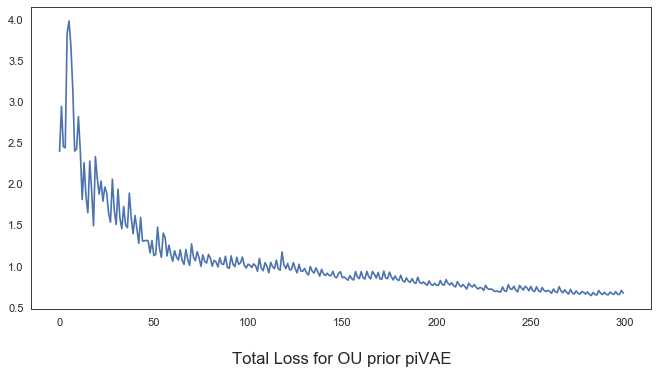

In [199]:
plt.plot(Loss_per_epoch_append)
plt.title("Total Loss for OU prior piVAE", fontsize=15, y=-0.2 )
plt.show()

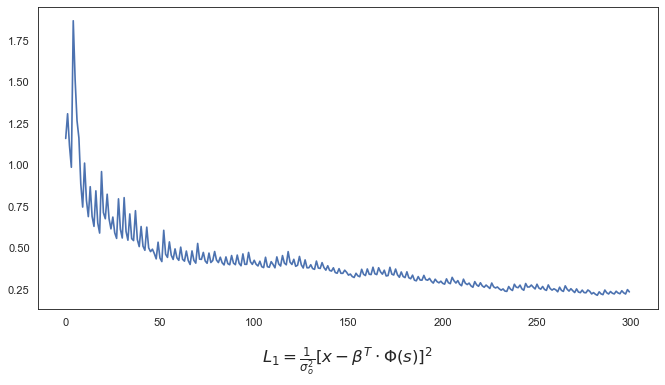

In [200]:
plt.plot(L1_per_epoch_append)
plt.title(r'$L_1=\frac{1}{\sigma_{o}^2}[x-\beta^T\cdot\Phi(s)]^2}$', fontsize=15, y=-0.2 )
plt.show()

Text(0.5, -0.2, '$L_2=\\frac{1}{\\sigma_o^2}[x-\\hat\\beta^T\\cdot\\Phi(s)]^2}$')

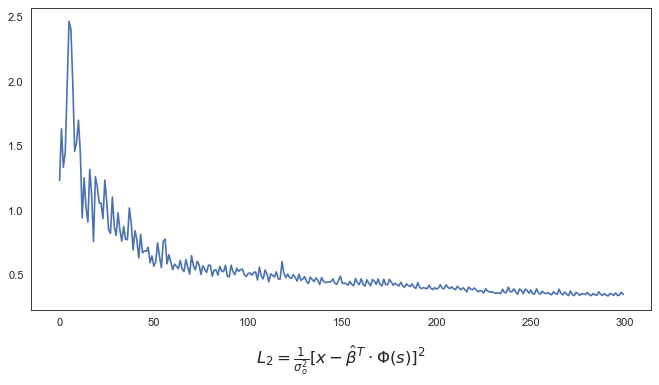

In [201]:
plt.plot(L2_per_epoch_append)
plt.title(r'$L_2=\frac{1}{\sigma_o^2}[x-\hat\beta^T\cdot\Phi(s)]^2}$',fontsize=15, y=-0.2)

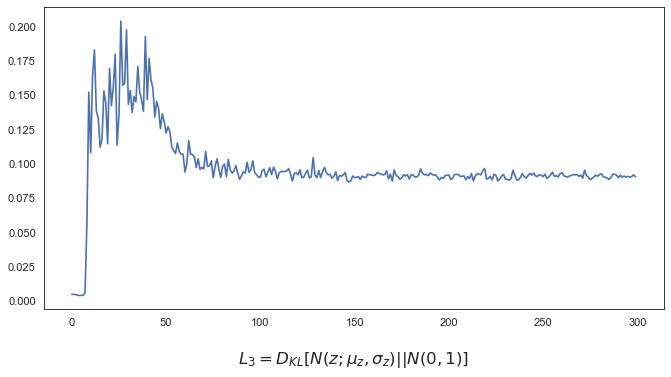

In [202]:
plt.plot(L3_per_epoch_append)
plt.title(r'$L_3=D_{KL}[N(z; \mu_z, \sigma_z)||N(0,1)]$', fontsize=15, y=-0.2)
plt.show()

### Generate samples from piVAE using $z \sim N(0,1):$

In [35]:
locations_np=np.arange(0,1000, 10)
locations_tensor=torch.tensor(locations_np)
locations_tensor=locations_tensor.unsqueeze(1)
locations=locations_tensor.double()
locations_tensor.shape

torch.Size([100, 1])

In [37]:
num_samples=5
samples=pivae_model.generate_x_samples_from_pivae(locations, num_samples)

In [38]:
samples = samples.detach().cpu().numpy()
locations = locations.detach().cpu().numpy()

In [165]:
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 80


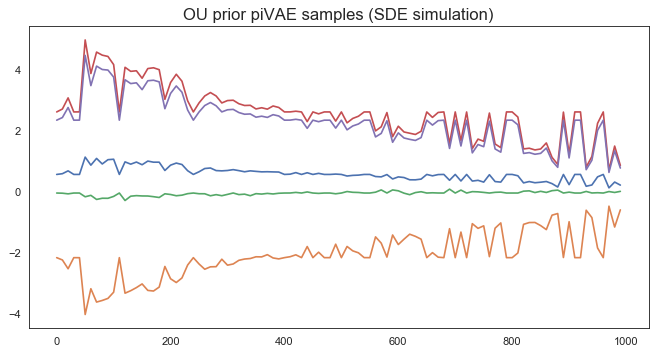

In [203]:
for i in range(samples.shape[0]):
    plt.plot(locations, samples[i, :])
plt.title("OU prior piVAE samples (SDE simulation)", fontsize=15)
plt.show()

In [49]:
def plot_decoded_x_samples_from_z_posterior(model, z_samples_from_post, s_star_tensor, x_star_tensor):    
            
    for i in range(z_samples_from_post.shape[0]):
        # Evaluates decoded x at location test_points when the value of the latent z_samples are given
        decoded_x = model.evaluate_decoded_x_at_given_z(z_samples_from_post[i,:],
                                                           test_pts_for_plot_tensor.unsqueeze(1))

        plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='black')

    
    plt.scatter(s_star_tensor.detach().numpy(), x_star_tensor.detach().numpy(), s=1000, marker="+")
    plt.show()

In [50]:
# Compute a quantity proportional to p(z|x, s) where x and s are new test points
def get_unnormalized_log_posterior(model, s, x, z, obs_sigma):        
        
    #z ~ N(0,1)
    log_prior = -0.5 * torch.sum(z**2)

    phi_s = model.Phi(s)

    beta_hat = model.decoder(z)
    
    x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
    
    x=torch.squeeze(x)
    
    #GAUSSIAN LL 
    log_likelihoods = (-1 / (2 * obs_sigma**2)) * (x_dec - x)**2

    return log_prior + torch.sum(log_likelihoods)

In [51]:
def draw_MCMC_z_samples(model, nbr_z_samples, z_starting_point, MH_proposal_sigma, obs_sigma, s_star_tensor, x_star_tensor):
        
    z = z_starting_point
    #create a tensor of zeros to contain the z values that are going to be sampled
    z_samples = torch.zeros((nbr_z_samples, z_dim)).double()

    acceptance_prob_sum = 0

    for z_sample in range(nbr_z_samples):
        if(z_sample %1000==0):
            print("sample_id",z_sample)
        #z_p ~ N(z,MH_sigma**2)
        z_proposed = z + torch.randn_like(z) * MH_proposal_sigma**2            

        log_posterior_z = get_unnormalized_log_posterior(model, s_star_tensor, 
                                                         x_star_tensor, z, obs_sigma)

        log_posterior_z_proposed = get_unnormalized_log_posterior(model, s_star_tensor, 
                                                                x_star_tensor, z_proposed, obs_sigma)

        MH_ratio = torch.exp(log_posterior_z_proposed - log_posterior_z)

        acceptance_prob = torch.min(torch.tensor(1.0).double(), MH_ratio)

        u = torch.rand(1).double()

        if u < acceptance_prob:
            z = z_proposed

        z_samples[z_sample, :] = z

        acceptance_prob_sum += acceptance_prob.detach()

    print("mean acceptance prob", acceptance_prob_sum/nbr_z_samples)
    return z_samples


In [52]:
sigma = 1.0
mu = 0.0  
theta = 2.0  

#stationary_std=sigma/(np.sqrt(2*theta))
#stationary_std

/Users/tresniaberah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if sys.path[0] == '':


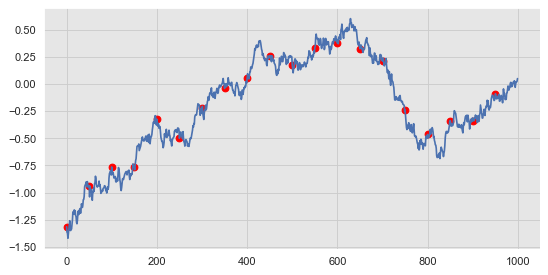

In [53]:
OU_whole_path_ground_truth = np.zeros(n_steps)

#OU_whole_path_ground_truth[0]=np.random.normal(mu, stationary_std)  

OU_whole_path_ground_truth[0]=np.random.uniform(-5,5)
                           
for i in range(n_steps-1):
    OU_whole_path_ground_truth[i + 1] = OU_whole_path_ground_truth[i] + (mu - OU_whole_path_ground_truth[i]) * theta*dt + sigma * np.sqrt(dt) * np.random.randn()
            
indices_star_20_np=np.arange(0,1000,50)

indices_star_20_np=np.expand_dims(indices_star_20_np,2)
indices_star_20_tensor=torch.tensor(indices_star_20_np)

OU_star_20_np=np.zeros(20)

for i in range(20):
    OU_star_20_np[i]=OU_whole_path_ground_truth[indices_star_20_np[i]]


plt.scatter(indices_star_20_np, OU_star_20_np, color='r')

plt.plot(OU_whole_path_ground_truth)

In [59]:
s_star_np=np.arange(0,1000,1)
s_star_np.shape

(1000,)

In [63]:
x_star_np=OU_whole_path_ground_truth
x_star_np.shape

(1000,)

In [66]:
import pandas as pd
#create a data frame with 2 columns: one for the s_star and one for the x_star
df=pd.DataFrame(s_star_np)
df['x_star']=x_star_np
df['s_star']=s_star_np
df.shape

(1000, 3)

In [68]:
#select observations from ground truth
nbr_obs=10
s_obs=np.zeros(nbr_obs)
x_obs=np.zeros(nbr_obs)

k=int(len(s_star_np)/nbr_obs)
print(k)
for i in range(nbr_obs):
    s_obs[i]=df['s_star'][k*i]
    x_obs[i]=df['x_star'][k*i]
s_obs.shape

100


(10,)

In [69]:
#add noise to ground truth
sigma_noise=0.1
epsilon = np.random.normal(loc=0, scale=sigma_noise, size=len(x_obs))
epsilon.shape
y_obs=np.zeros(nbr_obs)
y_obs.shape
y_obs=x_obs +epsilon
y_obs.shape

(10,)

nbr observations: 10


Text(0.5, 1.0, 'Ground truth OU prior and 10 observations')

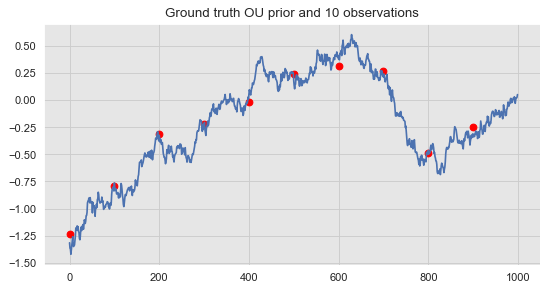

In [70]:
plt.plot(s_star_np, x_star_np, label='Ground truth')
plt.scatter(s_obs, y_obs, color='r')
print("nbr observations:", len(y_obs))
length=len(y_obs)
plt.title('Ground truth OU prior and 10 observations')
#plt.show()


In [181]:
z = torch.ones((z_dim,)).double()
#when MH_proposal_sigma increases the credible interval gets too narrow 
#when obs_sigma decreases: the mean posterior gets closer to the ground truth

nbr_iter=50000
MH_proposal_sigma=0.5
obs_sigma=1.5

mcmc_samples = draw_MCMC_z_samples(pivae_model, nbr_iter, z, MH_proposal_sigma, obs_sigma, torch.tensor(s_obs).unsqueeze(1), 
                                        torch.tensor(y_obs))

sample_id 0
sample_id 1000
sample_id 2000
sample_id 3000
sample_id 4000
sample_id 5000
sample_id 6000
sample_id 7000
sample_id 8000
sample_id 9000
sample_id 10000
sample_id 11000
sample_id 12000
sample_id 13000
sample_id 14000
sample_id 15000
sample_id 16000
sample_id 17000
sample_id 18000
sample_id 19000
sample_id 20000
sample_id 21000
sample_id 22000
sample_id 23000
sample_id 24000
sample_id 25000
sample_id 26000
sample_id 27000
sample_id 28000
sample_id 29000
sample_id 30000
sample_id 31000
sample_id 32000
sample_id 33000
sample_id 34000
sample_id 35000
sample_id 36000
sample_id 37000
sample_id 38000
sample_id 39000
sample_id 40000
sample_id 41000
sample_id 42000
sample_id 43000
sample_id 44000
sample_id 45000
sample_id 46000
sample_id 47000
sample_id 48000
sample_id 49000
mean acceptance prob tensor(0.3652, dtype=torch.float64)


In [184]:
mcmc_selected_samples_run1 = mcmc_samples[5000::500,:]

In [185]:
mcmc_selected_samples_run1.shape

torch.Size([90, 25])

In [186]:
test_pts_for_plot_tensor = torch.arange(0, 1000, 1).double() 
test_pts_for_plot_tensor.shape    

torch.Size([1000])

In [187]:
test_pts_for_plot_np = np.arange(0,1000, 1)
test_pts_for_plot_np.shape    

(1000,)

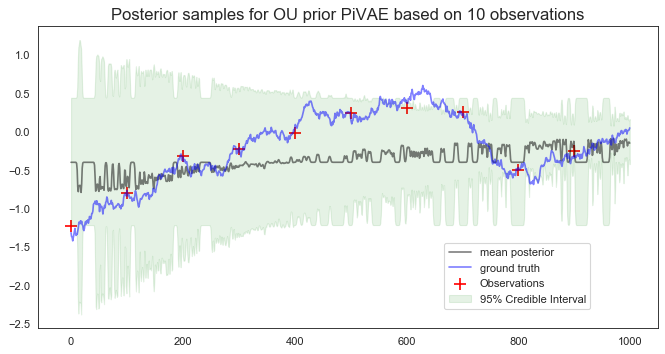

In [198]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run1)):
        
    decoded_x = pivae_model.evaluate_decoded_x_at_given_z(mcmc_selected_samples_run1[i,:], 
                                                             test_pts_for_plot_tensor.unsqueeze(1))
    
    #plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='grey')
    
    all_dec_x.append(decoded_x.detach().numpy())  
      
mean_dec_x=np.mean(np.array(all_dec_x), axis=0)

quantile_0975_dec_x=np.quantile(np.array(all_dec_x),0.975,axis=0)

quantile_0025_dec_x=np.quantile(np.array(all_dec_x),0.025,axis=0)
    
plt.plot(test_pts_for_plot_np, mean_dec_x, alpha=0.5, color='k', label='mean posterior')
    
plt.scatter(s_obs, y_obs, color="red", s=100, marker="+", label="Observations")
plt.plot(s_star_np, x_star_np, alpha=0.5, color='b', label="ground truth")

plt.fill_between(test_pts_for_plot_np, quantile_0025_dec_x, quantile_0975_dec_x,
                    facecolor="green",
                    color='green', 
                    alpha=0.1, label = '95% Credible Interval') 
#bbox_to_anchor=(1.4,1.0)
plt.legend(bbox_to_anchor=(0.9,.3))
plt.title("Posterior samples for OU prior PiVAE based on 10 observations", fontsize=15)
plt.show()

In [134]:
#select 20 new points from the dataframe
nbr_new_star=5
s_obs_20=np.zeros(nbr_new_star)
x_obs_20=np.zeros(nbr_new_star)
for i in range(nbr_new_star):
    s_obs_20[i]=df['s_star'][180*i+80]
    x_obs_20[i]=df['x_star'][180*i+80]
x_obs_20.shape

(5,)

Text(0.5, 1.0, 'Ground truth OU prior')

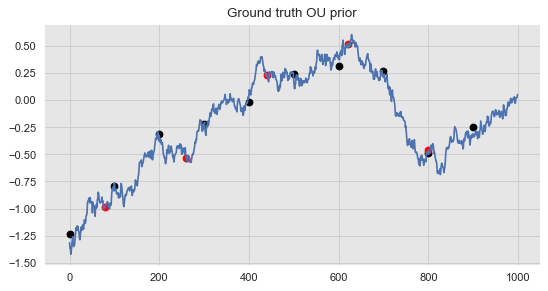

In [135]:
plt.plot(s_star_np, x_star_np, label='Ground truth')
plt.scatter(s_obs, y_obs, color='k')
plt.scatter(s_obs_20, x_obs_20,color="r")
#plt.scatter(s_star_np, y_obs, color='r', label='Noisy Observations')

#plt.legend(loc='upper left', borderaxespad=0.)
plt.title('Ground truth OU prior')
#plt.show()

In [189]:
#now we need to compute the posterior at these 20 new points
#the way to do this is to run MCMC on these samples and take the mean posterior of these samples
nbr_iter_2=10000
mcmc_samples2 = draw_MCMC_z_samples(pivae_model, nbr_iter_2, z, MH_proposal_sigma, obs_sigma, 
                                   torch.tensor(s_obs_20).unsqueeze(1), torch.tensor(x_obs_20))

sample_id 0
sample_id 1000
sample_id 2000
sample_id 3000
sample_id 4000
sample_id 5000
sample_id 6000
sample_id 7000
sample_id 8000
sample_id 9000
mean acceptance prob tensor(0.4235, dtype=torch.float64)


In [190]:
mcmc_selected_samples_run2 = mcmc_samples2[1000::100,:]

In [191]:
mcmc_selected_samples_run2.shape

torch.Size([90, 25])

In [192]:
def eval_decoded_x_at_given_z(model, z, s):        
        phi_s = model.Phi(s)       
        beta_hat = model.decoder(z)        
        x_dec = torch.matmul(phi_s, beta_hat)        
        return x_dec   

In [193]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run2)):
    decoded_new_x = eval_decoded_x_at_given_z(pivae_model, mcmc_selected_samples_run2[i,:], 
                                                             torch.tensor(s_obs_20).unsqueeze(1))

    all_dec_x.append(decoded_new_x.detach().numpy())  
      
new_star_mean_post=np.mean(np.array(all_dec_x), axis=0)
new_star_mean_post.shape
#nbr_new_star=5
RMSE=np.sqrt(np.sum((new_star_mean_post - x_obs_20)**2/nbr_new_star))
RMSE

0.44312335308786166

In [194]:
#dataset_Andrew_sin_s, dataset_Andrew_sin_x
def check_beta(model, id):
    
    test_points = torch.arange(0, 1000, 10).reshape(100, 1)
    
    phi_s = model.Phi(test_points)
    
    beta = model.betas[id, :]
    
    x_encs = torch.matmul(phi_s, beta)
    
    z_mean, z_std = model.encoder(beta.unsqueeze(0))
    
    beta_hat = model.decoder(z_mean)
    
    x_decs = torch.matmul(beta_hat, torch.transpose(phi_s, 0, 1))
    
    #plot encoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy(), x_encs.detach().cpu().numpy(), color='red')
    
    #plot decoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy().reshape(100), x_decs.detach().cpu().numpy().reshape(100), color='green')
    
    plt.scatter(dataset_indices[id].reshape(K), dataset_OU[id].reshape(K))
    plt.show()

In [102]:
def check_beta(model, id):
    
    test_points = torch.arange(0, 1000, 1).reshape(1000, 1)
    
    phi_s = model.Phi(test_points)
    
    beta = model.betas[id, :]
    
    x_encs = torch.matmul(phi_s, beta)
    
    z_mean, z_std = model.encoder(beta.unsqueeze(0))
    
    beta_hat = model.decoder(z_mean)
    
    x_decs = torch.matmul(beta_hat, torch.transpose(phi_s, 0, 1))
    
    #plot encoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy(), x_encs.detach().cpu().numpy(), color='red')
    
    #plot decoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy().reshape(1000), x_decs.detach().cpu().numpy().reshape(1000), color='green')
    
    plt.scatter(dataset_indices[id].reshape(K), dataset_OU[id].reshape(K))
    plt.title("Reconstruction of training data")
    plt.show()

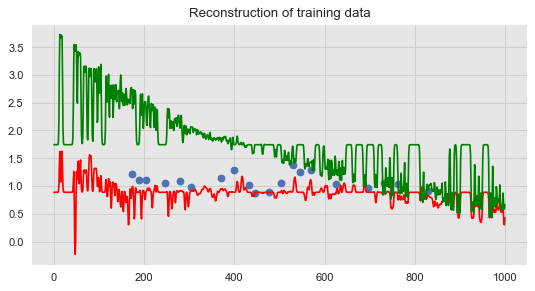

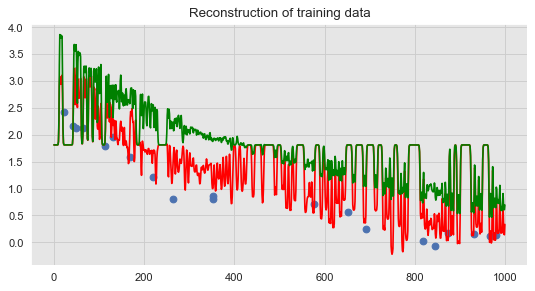

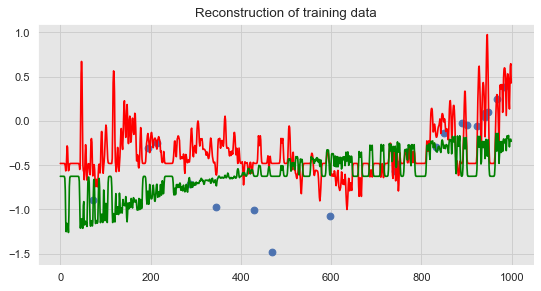

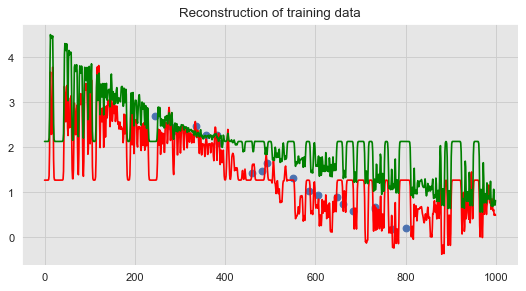

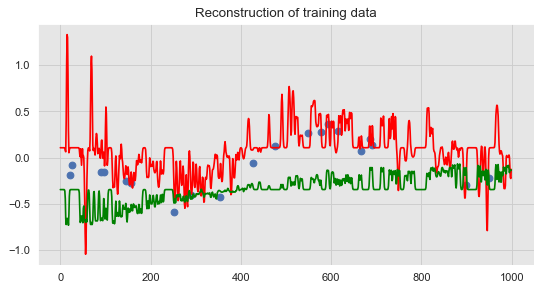

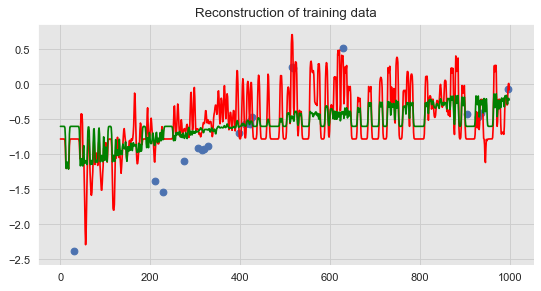

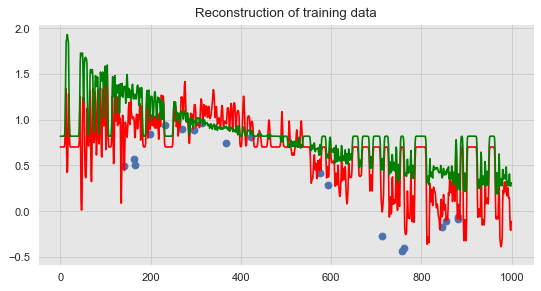

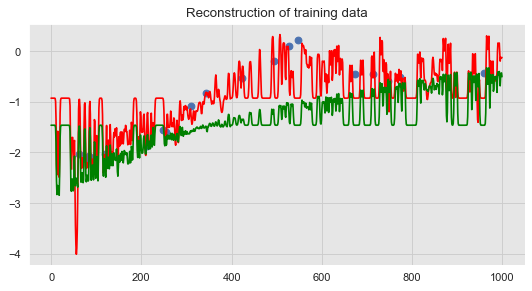

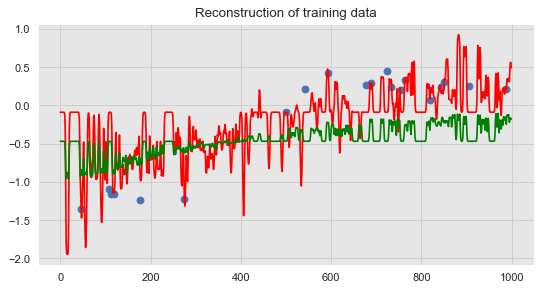

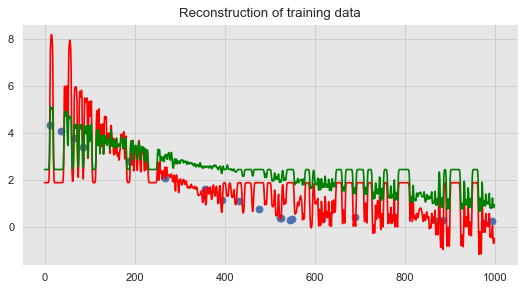

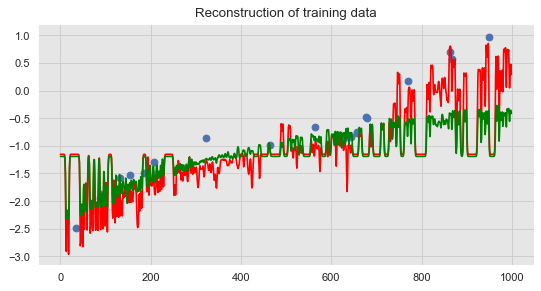

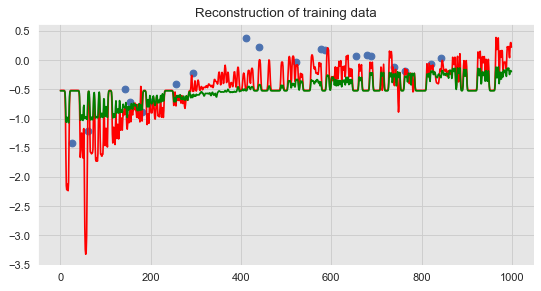

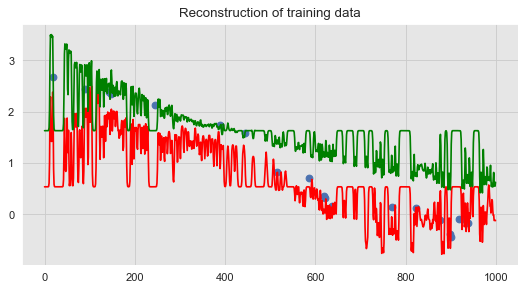

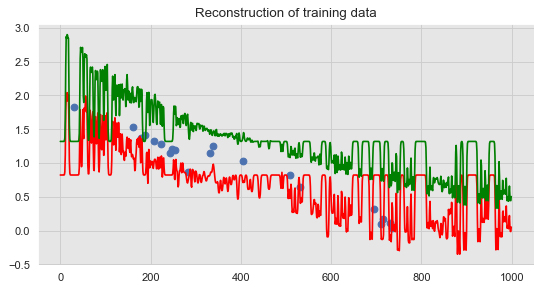

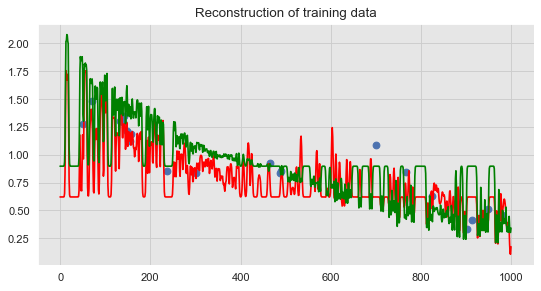

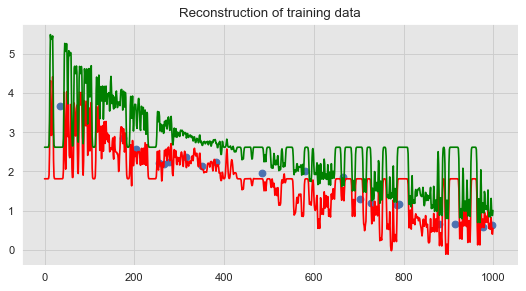

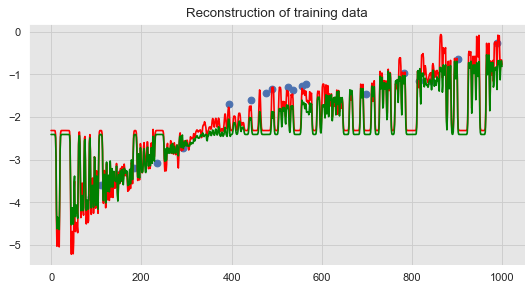

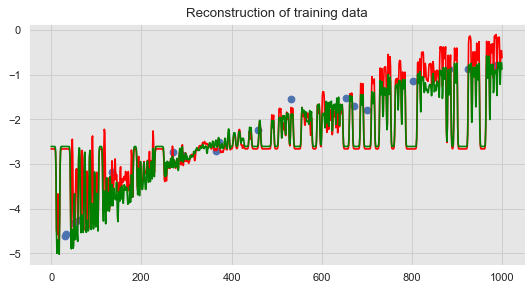

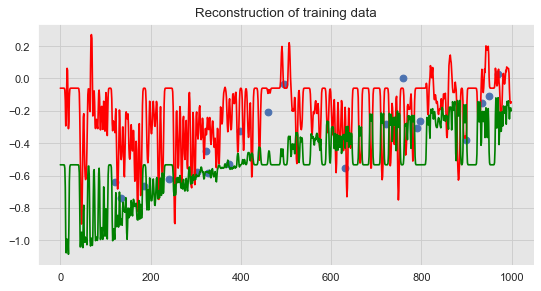

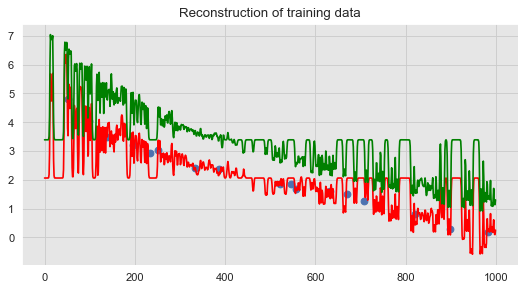

In [103]:
# ------ Check reconstructions of training data -------
for i in range(20):
    check_beta(pivae_model, i)
#%%